In [5]:
import tensorflow as tf
import numpy as np
import pandas as pd
import sys
import pickle
import scipy
from scipy import misc
import glob
from PIL import Image
import os
import matplotlib.pyplot as plt
import librosa
from keras import layers
from keras.layers import (Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, 
                          Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D)
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model
from tensorflow.keras.optimizers import Adam
from keras.initializers import glorot_uniform
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from pydub import AudioSegment
import shutil
from keras.preprocessing.image import ImageDataGenerator
import random
import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings("ignore")

In [6]:
# Reading the CSV file.
df = pd.read_csv('Data/features_3_sec.csv')
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [7]:
# Footer part of the file.
df.tail()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
9985,rock.00099.5.wav,66149,0.349126,0.080515,0.050019,0.000097,1499.083005,164266.886443,1718.707215,85931.574523,...,42.485981,-9.094270,38.326839,-4.246976,31.049839,-5.625813,48.804092,1.818823,38.966969,rock
9986,rock.00099.6.wav,66149,0.372564,0.082626,0.057897,0.000088,1847.965128,281054.935973,1906.468492,99727.037054,...,32.415203,-12.375726,66.418587,-3.081278,54.414265,-11.960546,63.452255,0.428857,18.697033,rock
9987,rock.00099.7.wav,66149,0.347481,0.089019,0.052403,0.000701,1346.157659,662956.246325,1561.859087,138762.841945,...,78.228149,-2.524483,21.778994,4.809936,25.980829,1.775686,48.582378,-0.299545,41.586990,rock
9988,rock.00099.8.wav,66149,0.387527,0.084815,0.066430,0.000320,2084.515327,203891.039161,2018.366254,22860.992562,...,28.323744,-5.363541,17.209942,6.462601,21.442928,2.354765,24.843613,0.675824,12.787750,rock
9989,rock.00099.9.wav,66149,0.369293,0.086759,0.050524,0.000067,1634.330126,411429.169769,1867.422378,119722.211518,...,38.801735,-11.598399,58.983097,-0.178517,55.761299,-6.903252,39.485901,-3.412534,31.727489,rock


In [8]:
# Shape of the Data
df.shape

(9990, 60)

In [10]:
# Data Types
df.dtypes

filename                    object
length                       int64
chroma_stft_mean           float64
chroma_stft_var            float64
rms_mean                   float64
rms_var                    float64
spectral_centroid_mean     float64
spectral_centroid_var      float64
spectral_bandwidth_mean    float64
spectral_bandwidth_var     float64
rolloff_mean               float64
rolloff_var                float64
zero_crossing_rate_mean    float64
zero_crossing_rate_var     float64
harmony_mean               float64
harmony_var                float64
perceptr_mean              float64
perceptr_var               float64
tempo                      float64
mfcc1_mean                 float64
mfcc1_var                  float64
mfcc2_mean                 float64
mfcc2_var                  float64
mfcc3_mean                 float64
mfcc3_var                  float64
mfcc4_mean                 float64
mfcc4_var                  float64
mfcc5_mean                 float64
mfcc5_var           

In [11]:
# Dropping the first column "filename" as it is unnecessary.
df = df.drop(labels = 'filename',axis = 1)
df.head()

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [12]:
# Understanding the Audio Files

audio_recording = "Data/genres_original/country/country.00055.wav"
data, sr = librosa.load(audio_recording)
print(type(data), type(sr))

<class 'numpy.ndarray'> <class 'int'>


In [13]:
data, sr = librosa.load(audio_recording)

In [14]:
librosa.load(audio_recording, sr = 45600)

(array([0.08956517, 0.12055705, 0.1210661 , ..., 0.11570406, 0.11173078,
        0.05956393], dtype=float32),
 45600)

In [15]:
import IPython
IPython.display.Audio(data, rate=sr)

## Visualizing Audio Files

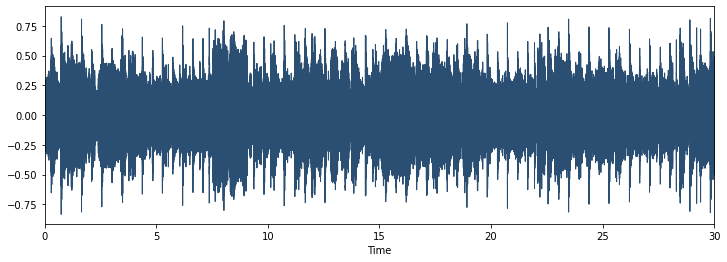

In [16]:
## Waveform of the audio file.

plt.figure(figsize = (12, 4))
librosa.display.waveplot(data, color = "#2B4F72")
plt.show()

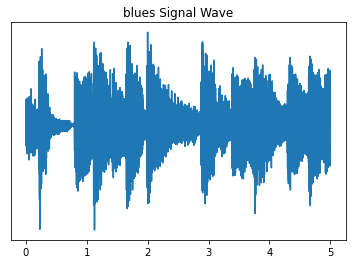

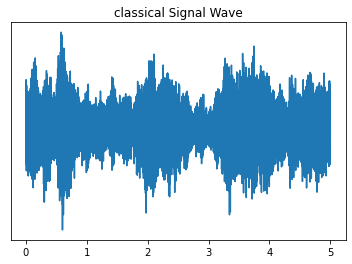

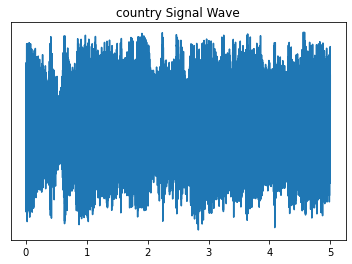

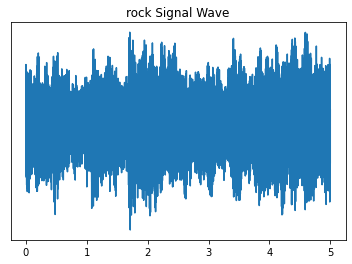

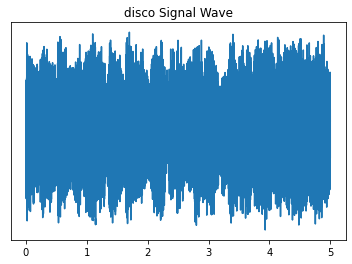

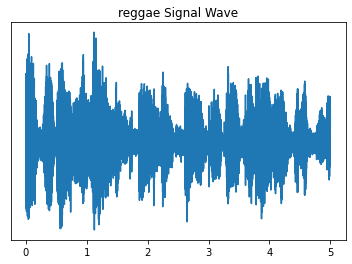

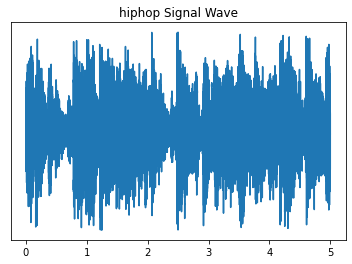

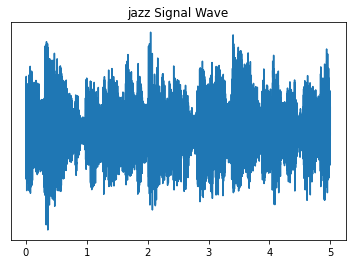

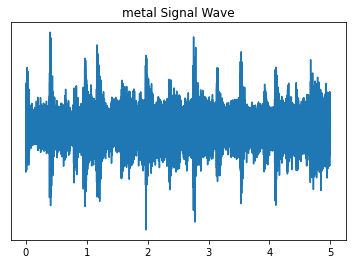

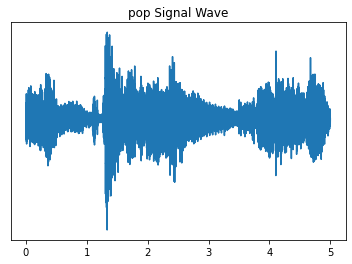

In [18]:
##  Signal Waveform of different genre's audio files.

genres='blues classical country rock disco reggae hiphop jazz metal pop'.split()
for i,genre in enumerate(genres):
    y,sr=librosa.load('Data/genres_original/'+genre+'/'+genre+'.00005.wav',duration=5.0,sr=None,)
    time=np.linspace(0,len(y)/sr,num=len(y))
    plt.figure(i+1)
    plt.title(genre+" Signal Wave")
    plt.yticks(ticks=[])
    plt.plot(time,y)
    plt.savefig(fname=genre+'_time_domain',quality=95,dpi=200)
    plt.show()

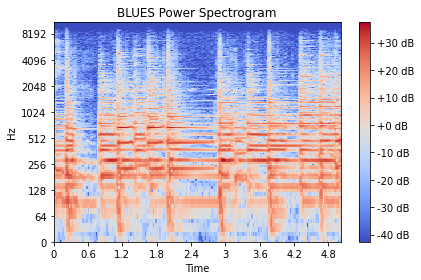

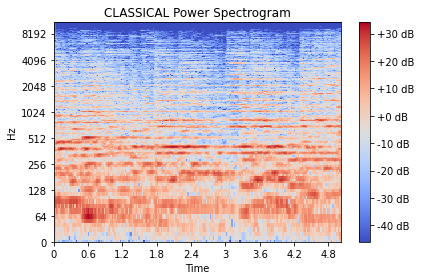

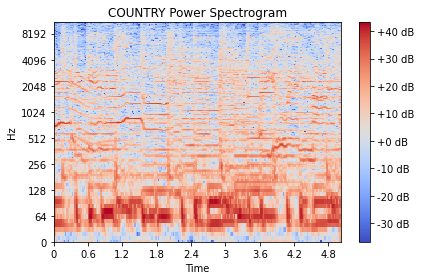

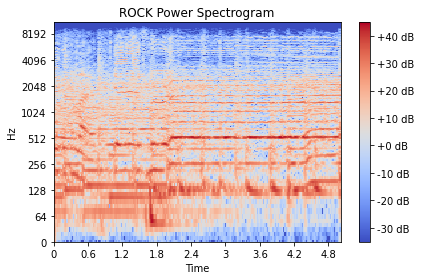

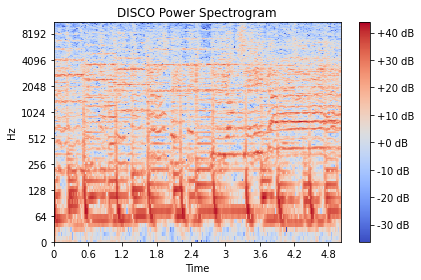

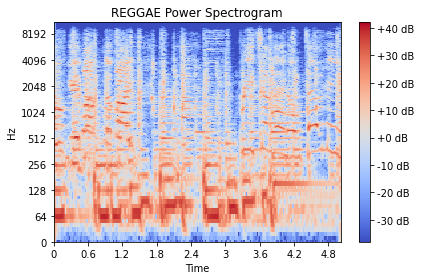

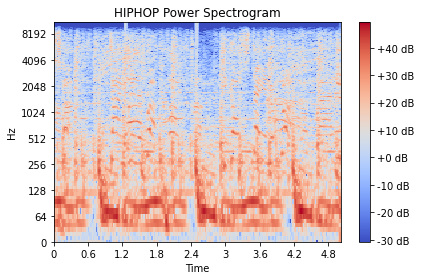

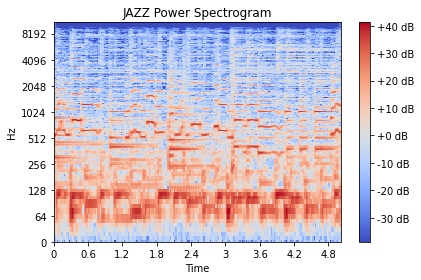

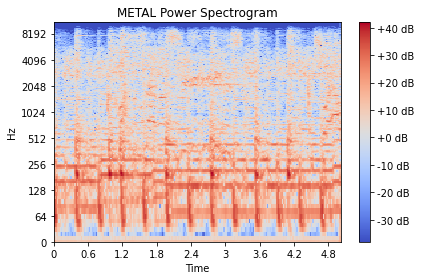

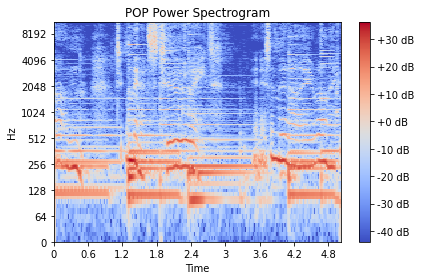

In [19]:
## Spectrograms of different genre's audio files.

for i,genre in enumerate(genres):
    y,sr=librosa.load('Data/genres_original/'+genre+'/'+genre+'.00005.wav',duration=5.0,sr=None,)
    librosa.display.specshow(librosa.amplitude_to_db(abs(librosa.stft(y)),ref=1.0),
                         y_axis='log', x_axis='time')
    plt.title(genre.upper()+" Power Spectrogram")
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.savefig(fname=genre+'_power_spectrogram',quality=95,dpi=200)
    plt.show()

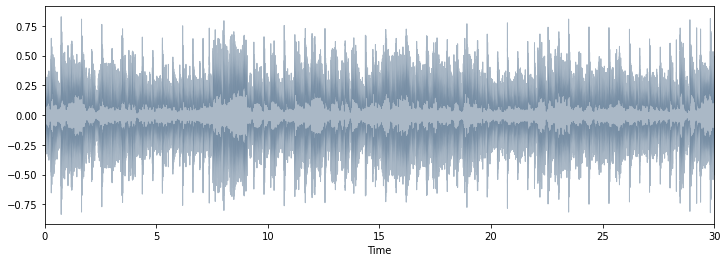

In [20]:
## Spectral Rolloff
### Spectral Rolloff is the frequency below which a specified
### percentage of the total spectral energy, e.g. 85%

from sklearn.preprocessing import normalize
spectral_rolloff = librosa.feature.spectral_rolloff(data+0.01, sr = sr)[0]
plt.figure(figsize = (12,4))
librosa.display.waveplot(data, sr = sr, alpha = 0.4, color = "#2B4F72")


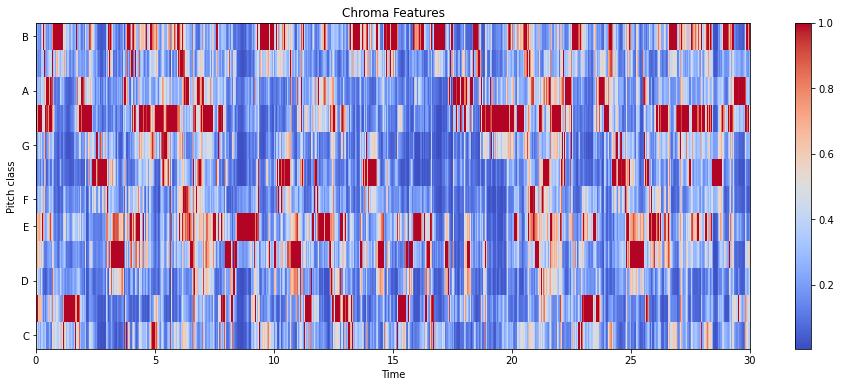

In [21]:
## Chroma Features

import librosa.display as lplt
chroma = librosa.feature.chroma_stft(data, sr=sr)
plt.figure(figsize = (16,6))
lplt.specshow(chroma,sr = sr, x_axis = 'time',y_axis = 'chroma', cmap = 'coolwarm')
plt.colorbar()
plt.title("Chroma Features")
plt.show()

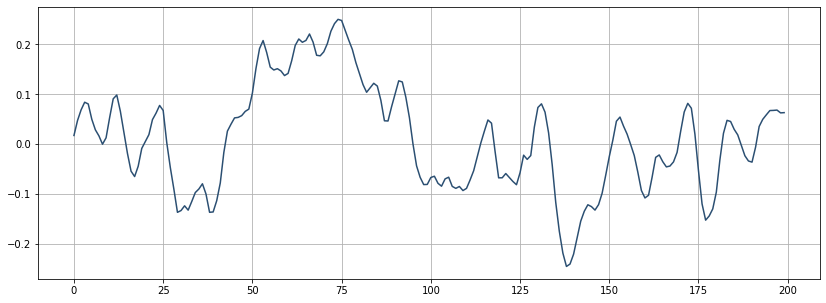

In [22]:
## Zero Crossing Rate

start  = 1000
end = 1200
plt.figure(figsize = (14,5))
plt.plot(data[start:end], color='#2B4F72')
plt.grid()

In [23]:
zero_crossing_rate = librosa.zero_crossings(data[start:end], pad = False)
print("The number of zero-crossings is :",sum(zero_crossing_rate))

The number of zero-crossings is : 16
